In [1]:
# For importing and preparing data 
import os, cv2, re, random
import numpy as np
import pandas as pd
from tqdm import tqdm
# For visualization
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline
# For modeling
from keras.layers import Input, Convolution2D, MaxPooling2D
from keras.models import Model, Sequential
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import optimizers
from tensorflow import keras
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
from keras import optimizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

TRAIN_DIR = "/content/drive/My Drive/6420-Predictive/HW4/train/"
TEST_DIR = "/content/drive/My Drive/6420-Predictive/HW4/test/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:


train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

IMG_SIZE = 150
CHANNELS = 3
EPOCHES = 3

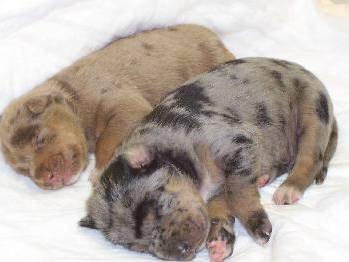

In [5]:
# check some images
load_img(train_dogs[0])

In [6]:
# not all the images are perfectly squared
# Generate the labels
labels = []
for i in os.listdir(TRAIN_DIR):
    if 'dog' in i:
        labels.append('dog')
    else:
        labels.append('cat')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


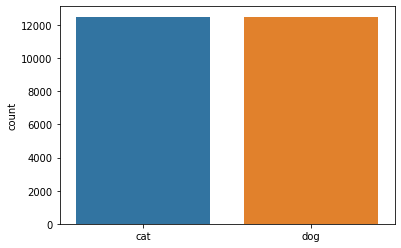

In [7]:
sns.countplot(labels)

In [8]:
train_df = pd.DataFrame(data = {'img_filepath': os.listdir(TRAIN_DIR), 'label': labels})
train_df.head(5)

,img_filepath,label
0,cat.10224.jpg,cat
1,cat.1022.jpg,cat
2,cat.10215.jpg,cat
3,cat.10219.jpg,cat
4,cat.10213.jpg,cat


In [9]:
train_df, validate_df = train_test_split(train_df, test_size=0.20, random_state=56)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [10]:
train_df['label'].value_counts()

cat    10018
dog     9982
Name: label, dtype: int64

In [11]:
validate_df['label'].value_counts()

dog    2518
cat    2482
Name: label, dtype: int64

In [12]:
train_df = train_df[train_df['img_filepath'] != 'cat.10949.jpg']
train_df = train_df[train_df['img_filepath'] != 'cat.10166.jpg']

In [23]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='img_filepath',
    y_col='label',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical',
    batch_size=15
)

Found 19998 validated image filenames belonging to 2 classes.


In [24]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAIN_DIR, 
    x_col='img_filepath',
    y_col='label',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical',
    batch_size=15
)

Found 5000 validated image filenames belonging to 2 classes.


In [25]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [26]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model2 = Sequential()
model2.add(VGG16(weights='imagenet', include_top=False, input_shape =(IMG_SIZE,IMG_SIZE,CHANNELS)))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))

model2.add(Dropout(0.5))
model2.add(Dense(2, activation ='softmax'))

In [27]:
model2.layers[0].trainable = False

In [28]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                      

In [29]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model2.compile(loss='categorical_crossentropy', optimizer= rmsprop, metrics=['accuracy'])

In [30]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [31]:
result = model2.fit(train_generator, 
                             epochs = 3, 
                             validation_data=validation_generator,
                             validation_steps=total_validate//batch_size,
                             steps_per_epoch=total_train//batch_size,
                             callbacks=callbacks, 
                             verbose = 1)

Epoch 1/3
1333/1333 [==============================] - 5890s 4s/step - loss: 0.4801 - accuracy: 0.8272 - val_loss: 0.3129 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 294s 220ms/step - loss: 0.3907 - accuracy: 0.8457 - val_loss: 0.2787 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 288s 216ms/step - loss: 0.3802 - accuracy: 0.8585 - val_loss: 0.3002 - val_accuracy: 0.9055 - lr: 0.0010


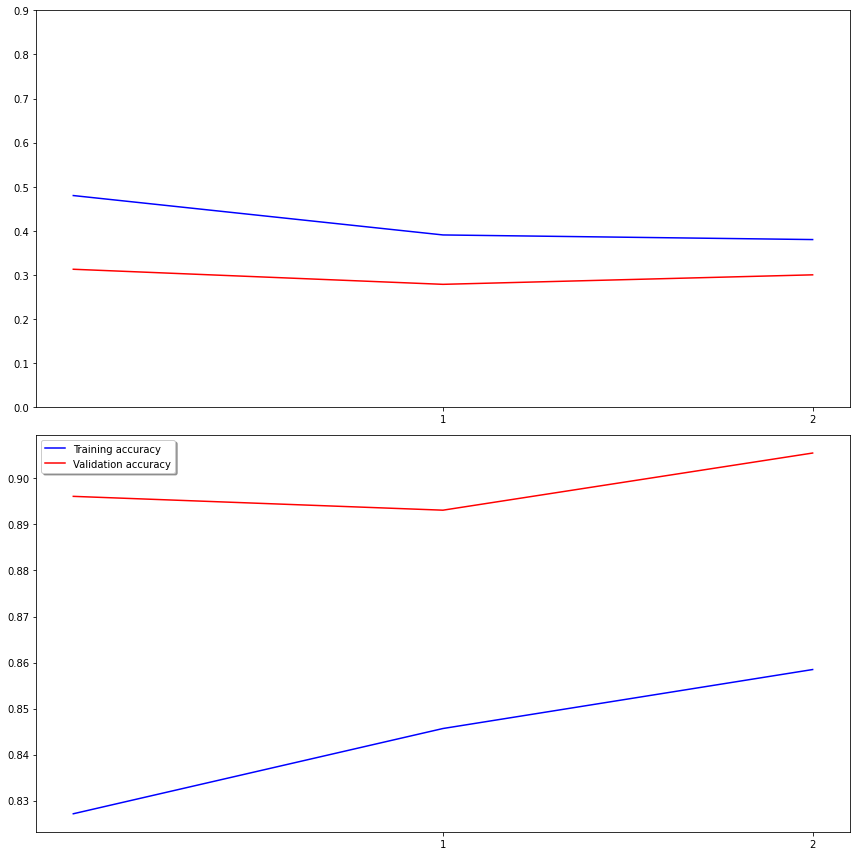

In [44]:
# Visualize the training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(result.history['loss'], color='b', label="Training loss")
ax1.plot(result.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHES, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(result.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(result.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHES, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [33]:
test_df = pd.DataFrame({'img_filepath': os.listdir(TEST_DIR)})
test_df = test_df[test_df['img_filepath'] != 'test']
nb_samples = test_df.shape[0]
nb_samples

12500

In [36]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    TEST_DIR, 
    x_col='img_filepath',
    y_col=None,
    class_mode=None,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [37]:
predict = model2.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [38]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df['label'] = predict[:,1]

test_df.tail()

,img_filepath,category,label
12495,1115.jpg,1,9.874257e-01
12496,1117.jpg,0,3.315846e-02
12497,1110.jpg,0,4.460806e-02
12498,1100.jpg,1,9.979593e-01
12499,1141.jpg,0,3.854508e-37


In [39]:
test_df['category'].value_counts()

0    6369
1    6131
Name: category, dtype: int64

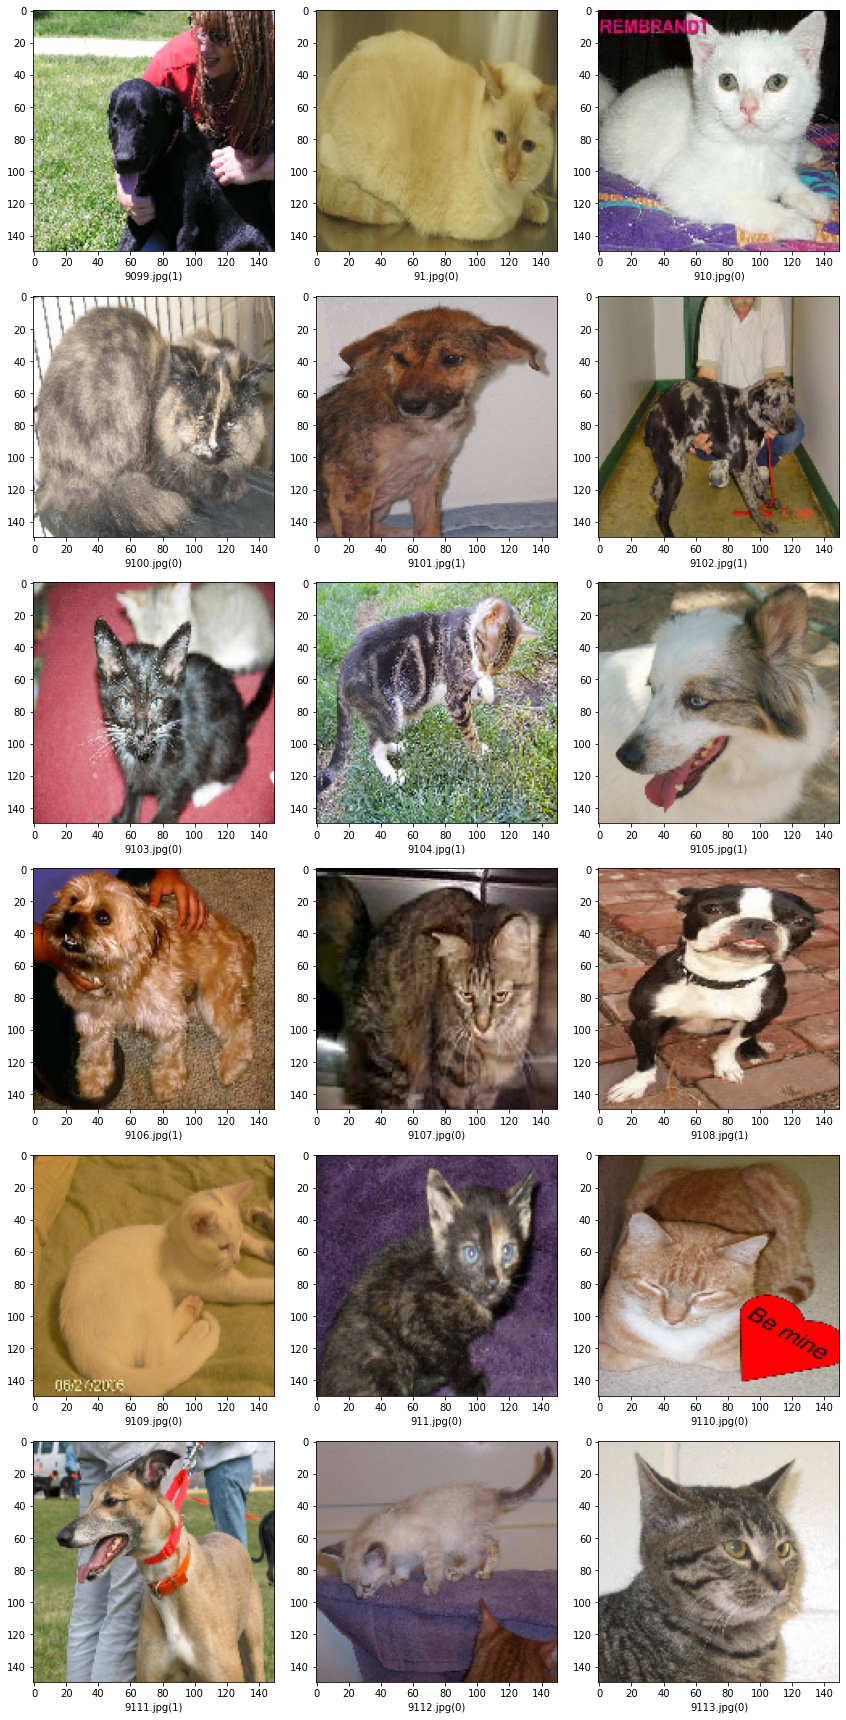

In [41]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['img_filepath']
    category = row['category']
    img = load_img("/content/drive/My Drive/6420-Predictive/HW4/test/"+filename, target_size=(IMG_SIZE, IMG_SIZE))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [42]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['img_filepath'].str.split('.').str[0]
submission_df.drop(['img_filepath','category'], axis=1, inplace=True)
submission_df = submission_df[['id', 'label']]
submission_df.to_csv('submission.csv', index=False)